## Introduction

This kernel shows how to use NBSVM (Naive Bayes - Support Vector Machine) to create a strong baseline for the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition. NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

If you're not familiar with naive bayes and bag of words matrices, I've made a preview available of one of fast.ai's upcoming *Practical Machine Learning* course videos, which introduces this topic. Here is a link to the section of the video which discusses this: [Naive Bayes video](https://youtu.be/37sFIak42Sc?t=3745).

In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
train = pd.read_csv('..//Datasets/toxiccomment/train.csv')
test = pd.read_csv('..//Datasets/toxiccomment/test.csv')
subm = pd.read_csv('..//Datasets/toxiccomment/sample_submission.csv')

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [8]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [11]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [13]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

The length of the comments varies a lot.

In [16]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

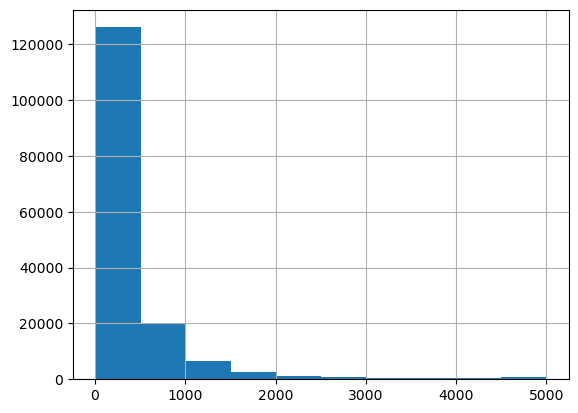

In [18]:
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [20]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
len(train),len(test)

(159571, 153164)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [23]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

C:\Users\MUDIT BAID\AppData\Local\Temp\ipykernel_5688\214498403.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[COMMENT].fillna("unknown", inplace=True)


## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

In [31]:
# keeping punctuations in sentences without removing them but separating them from the words to keep the words clean.
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors than the binarized features used in the paper. I don't think this has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [38]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=True,
               smooth_idf=True, sublinear_tf=True )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

D:\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation  below).

In [44]:
import joblib

# Save the trained vectorizer
joblib.dump(vec, "tfidf_vectorizer.pkl")

# Load the vectorizer later
# vec = joblib.load("tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [42]:
vec

TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True,
                tokenizer=<function tokenize at 0x00000280E83EE7A0>)

In [40]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775119 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765768 stored elements in Compressed Sparse Row format>)

Here's the basic naive bayes feature equation:

In [50]:
# Find out all th rows which have the label (y as the considered label (y_i)(ex:threat) from the vectorized matrix. 
# P is the sum of occurences for each work for class y_i. +1 is for smoothing...prevents division by 0. y==y_1 is 
# total no. of sentences having label as y_i.
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [48]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [68]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True,solver="liblinear",max_iter=500)
    x_nb = x.multiply(r)
    m.fit(x_nb, y)  # Train model

    # Save the trained model and log-count ratio
    joblib.dump((m, r), "log_nb_model.pkl")
    return m, r



In [70]:
get_mdl(train['threat'])

(LogisticRegression(C=4, dual=True, max_iter=500, solver='liblinear'),
 matrix([[1.28463148, 1.97831689, 0.74942583, ..., 5.59238215, 4.40615516,
          4.40615516]]))

In [66]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


And finally, create the submission file.

In [ ]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)